In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import os
import seaborn as sns
import cv2
from random import randint

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
       # print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [3]:

#os.getcwd()
#os.chdir('/Users/Aron/Kaggle/plant_pathology')

sample_submission = pd.read_csv('../input/plant-pathology-2020-fgvc7/sample_submission.csv')
test = pd.read_csv("../input/plant-pathology-2020-fgvc7/test.csv")
train = pd.read_csv("../input/plant-pathology-2020-fgvc7/train.csv")

train.head()



,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


image_id             Train_0Train_1Train_2Train_3Train_4Train_5Trai...
healthy                                                            516
multiple_diseases                                                   91
rust                                                               622
scab                                                               592
dtype: object
<class 'numpy.ndarray'>
(1365, 2048, 3)
<class 'tuple'>


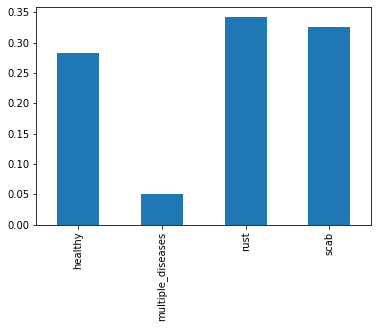

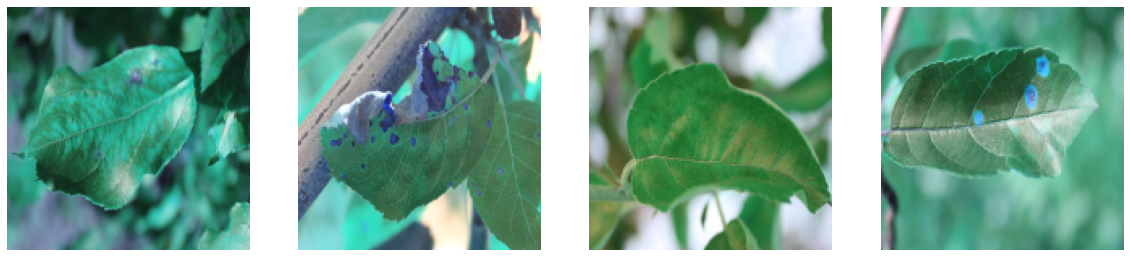

In [4]:

#The sample submission file, the training data and testing labels are read in.  ther eare 1821 training and testing images in the dataset.Next is to look at the distribution of the training set ategories.  

#There are 4 categories.  check to make sure there is a fatir representation of each of the 4 categories.

# since each image can only be represented in each column once, 
# the mean of the columns are the percentage each column is of the data.
print(train.sum())
pcts = train.mean()
pcts.plot(kind = 'bar')


#We can see that the multiple disease column is the least represented in the data.  

train['image_id']


#lets check out a couple of the images from the training set.

#Check image size
im = cv2.imread('../input/plant-pathology-2020-fgvc7/images/Train_0.jpg')
print(type(im))
print(im.shape)
print(type(im.shape))

#now resize and look at them

img_size = 150
train_image = []
for name in train['image_id']:
    path='../input/plant-pathology-2020-fgvc7/images/'+name+'.jpg'
    img=cv2.imread(path)
    image=cv2.resize(img,(img_size,img_size),interpolation=cv2.INTER_AREA)
    train_image.append(image)

fig, axis = plt.subplots(1, 4, figsize=(20, 20))
for i in range(4):
    axis[i].set_axis_off()
    axis[i].imshow(train_image[i])
    # randint(0,1500)+
    #generate different pictures from the test data.



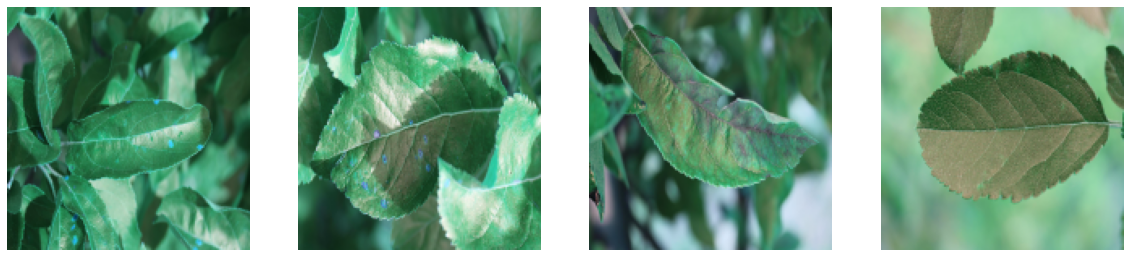

In [5]:
#Now check some test images

test_image = []
for name in test['image_id']:
    path='../input/plant-pathology-2020-fgvc7/images/'+name+'.jpg'
    img=cv2.imread(path)
    image=cv2.resize(img,(img_size,img_size),interpolation=cv2.INTER_AREA)
    test_image.append(image)

fig, axis = plt.subplots(1, 4, figsize=(20, 20))
for i in range(4):
    axis[i].set_axis_off()
    axis[i].imshow(test_image[i])
    # randint(0,1500)+
    #generate different pictures from the test data.



In [6]:

#shape the training images to work for keras.
x_train = np.asarray(train_image, dtype=np.float32)
x_train = x_train/255

x_train.shape

x_test = np.asarray(test_image, dtype=np.float32)
x_test = x_test/255

x_test.shape

type(train)


#grab the labels for the training images.
y = train.iloc[:,1:5]
# turn the labels into an arrray
y_train = np.array(y.values, dtype='float32')

#Check that the shape is correct.  1821 rows, 4 columns
#and check the value of the first row. should be floats
print(y_train.shape,y_train[0])



(1821, 4) [0. 0. 0. 1.]


#### Now add a convolution to the previous version's archetecture, and adjust things for better flow.


In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Input
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# resplit and shape the data again. the data to get a clean set.
x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                  y_train, 
                                                  test_size = 0.20, 
                                                  random_state = 403 )

Using TensorFlow backend.


In [8]:
#use the sequential model
cnn = Sequential()
I = Input(shape=(img_size, img_size, 3))
#add aconvolutional layer
cnn.add(Conv2D(25, kernel_size = (5,5), strides = (1,1), 
               padding = 'same',
               activation = 'relu',
               input_shape = (img_size, img_size, 3)
              )
       )

cnn.add(Conv2D(75, kernel_size = (5,5), strides = (1,1),
               padding = 'same',
               activation = 'relu',
               input_shape = (img_size, img_size, 3)
              )
       )
cnn.add(MaxPool2D(pool_size=(4,4)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(150, kernel_size = (3,3), strides = (1,1),
               padding = 'same',
               activation = 'relu',
               input_shape = (img_size, img_size, 3)
              )
       )
cnn.add(MaxPool2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))

cnn.add(Flatten())

cnn.add(Dense(300, activation='relu'))
cnn.add(Dropout(0.35))
cnn.add(Dense(150, activation='relu'))
cnn.add(Dropout(0.25))
# output layer
cnn.add(Dense(4, activation='softmax'))

optimizer_1 = Adam(lr=0.01)
optimizer_2 = SGD(lr=0.01)

cnn.compile(loss="categorical_crossentropy", optimizer=optimizer_1, metrics=["accuracy"])

In [9]:
cnn.fit(x_train,
        y_train,
        batch_size = 32,
        epochs = 50,
        validation_data = (x_val,y_val))

Train on 1456 samples, validate on 365 samples
Epoch 1/50
1456/1456 [==============================] - 7s 5ms/step - loss: 1.3799 - accuracy: 0.3304 - val_loss: 1.2390 - val_accuracy: 0.3315
Epoch 2/50
1456/1456 [==============================] - 2s 2ms/step - loss: 1.2530 - accuracy: 0.3317 - val_loss: 1.2437 - val_accuracy: 0.3616
Epoch 3/50
1456/1456 [==============================] - 2s 2ms/step - loss: 1.2406 - accuracy: 0.3626 - val_loss: 1.2538 - val_accuracy: 0.3260
Epoch 4/50
1456/1456 [==============================] - 2s 2ms/step - loss: 1.2405 - accuracy: 0.3565 - val_loss: 1.2496 - val_accuracy: 0.3205
Epoch 5/50
1456/1456 [==============================] - 3s 2ms/step - loss: 1.2384 - accuracy: 0.3606 - val_loss: 1.2490 - val_accuracy: 0.3233
Epoch 6/50
1456/1456 [==============================] - 3s 2ms/step - loss: 1.2235 - accuracy: 0.3777 - val_loss: 1.2298 - val_accuracy: 0.3753
Epoch 7/50
1456/1456 [==============================] - 2s 2ms/step - loss: 1.2015 - accu

In [10]:
predict = cnn.predict(x_test)

In [11]:
# predict using the trained model

predict= cnn.predict(x_test)



In [12]:
#convert the probabilties to binary predictions by taking the max of the row and turning to 1
prediction = np.ndarray(shape = (test.shape[0],4), dtype = np.float32)
for row in range(test.shape[0]):
    for col in range(4):
        if predict[row][col] == max(predict[row]):
            prediction[row][col] = 1
        else:
            prediction[row][col] = 0

#convert it to a data frame and add the image names. 



In [13]:
prediction = pd.DataFrame(prediction)
prediction.columns = ['healthy', 'multiple_diseases', 'rust', 'scab']
df = pd.concat([test.image_id, prediction], axis = 1)

df.head()
df.tail()


,image_id,healthy,multiple_diseases,rust,scab
1816,Test_1816,0.0,0.0,1.0,0.0
1817,Test_1817,0.0,0.0,0.0,1.0
1818,Test_1818,0.0,0.0,0.0,1.0
1819,Test_1819,1.0,0.0,0.0,0.0
1820,Test_1820,0.0,0.0,1.0,0.0


In [14]:
#Turn into a submission file
df.to_csv('submission.csv', index = False)

In [16]:
os.getcwd()

'/kaggle/working'

In [ ]:
 from IPython.display import FileLink
FileLink(r'submission.csv')